# Notebook 2:Baseline CNN Model

**Trash Hero - Tri Intelligent des Déchets par IA**

Dans ce notebook, nous allons :
1. Créer un CNN de base (baseline)
2. Entraîner le modèle sur notre dataset
3. Évaluer les performances
4. Visualiser les résultats

## 2.1 Imports et Configuration

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm

# Import des fonctions utilitaires
import sys
sys.path.append('..')
from utils import *

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

Device: cpu
CUDA disponible: False


## 2.2 Chargement des Données

In [10]:
# Chemins
PROJECT_ROOT = Path('..')
DATA_ROOT = PROJECT_ROOT / 'data'
PROCESSED_DATA_DIR = DATA_ROOT / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Charger les infos du dataset
with open(DATA_ROOT / 'data_info.json', 'r') as f:
    data_info = json.load(f)

n_classes = data_info['n_classes']
class_names = data_info['class_names']
IMG_SIZE = 128  
BATCH_SIZE = 8   

print(f"Dataset Info:")
print(f"  - Classes: {class_names}")
print(f"  - Nombre de classes: {n_classes}")
print(f"  - Taille d'image: {IMG_SIZE}x{IMG_SIZE}")

Dataset Info:
  - Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
  - Nombre de classes: 6
  - Taille d'image: 128x128


In [11]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Datasets et DataLoaders
train_dataset = ImageFolder(PROCESSED_DATA_DIR / 'train', transform=train_transforms)
valid_dataset = ImageFolder(PROCESSED_DATA_DIR / 'valid', transform=eval_transforms)
test_dataset = ImageFolder(PROCESSED_DATA_DIR / 'test', transform=eval_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_N = len(train_dataset)
valid_N = len(valid_dataset)
test_N = len(test_dataset)

print(f"\nDataLoaders créés")
print(f"  - Train: {train_N} images")
print(f"  - Valid: {valid_N} images")
print(f"  - Test: {test_N} images")


DataLoaders créés
  - Train: 2331 images
  - Valid: 746 images
  - Test: 744 images


## 2.3 Définition du Modèle CNN Baseline

Nous allons créer un CNN avec :
- 3 blocs convolutifs (Conv → BatchNorm → ReLU → MaxPool)
- 2 couches fully connected
- Dropout pour éviter l'overfitting

In [12]:
class WasteCNN(nn.Module):
    """CNN Baseline pour la classification des déchets"""
    
    def __init__(self, n_classes):
        super(WasteCNN, self).__init__()
        
        # Bloc 1: 3 → 32 channels
        self.conv1 = MyConvBlock(in_channels=3, out_channels=32, dropout_p=0.0)
        
        # Bloc 2: 32 → 64 channels
        self.conv2 = MyConvBlock(in_channels=32, out_channels=64, dropout_p=0.2)
        
        # Bloc 3: 64 → 128 channels
        self.conv3 = MyConvBlock(in_channels=64, out_channels=128, dropout_p=0.2)
        
        # Calculer la taille après les convolutions
        # Avec IMG_SIZE=128 et 3 MaxPool2d(2,2): 128 → 64 → 32 → 16
        flattened_size = 128 * 16 * 16 
        
        # Couches fully connected
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# Créer le modèle
model = WasteCNN(n_classes=n_classes).to(device)

print("\nModèle créé")
print(f"\n{model}")

# Compter les paramètres
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Nombre de paramètres entraînables: {n_params:,}")


Modèle créé

WasteCNN(
  (conv1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout2d(p=0.0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout2d(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv3): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2):

## 2.4 Configuration de l'Entraînement

In [13]:
# Loss et Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=0.001)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)


## 2.5 Fonctions d'Entraînement et de Validation

In [14]:
def train_epoch(model, train_loader, loss_function, optimizer, device):
    """Entraîne le modèle sur une epoch"""
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Métriques
        running_loss += loss.item()
        running_accuracy += get_batch_accuracy(outputs, labels, len(images))
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{get_batch_accuracy(outputs, labels, len(images)):.4f}'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    
    return epoch_loss, epoch_accuracy


def validate_epoch(model, valid_loader, loss_function, device):
    """Valide le modèle"""
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            running_loss += loss.item()
            running_accuracy += get_batch_accuracy(outputs, labels, len(images))
    
    epoch_loss = running_loss / len(valid_loader)
    epoch_accuracy = running_accuracy / len(valid_loader)
    
    return epoch_loss, epoch_accuracy

print("Fonctions d'entraînement définies")

Fonctions d'entraînement définies


## 2.6 Entraînement du Modèle

In [15]:
# Nettoyer la mémoire GPU
import gc

torch.cuda.empty_cache()
gc.collect()

print("Mémoire GPU nettoyée")
print(f"Mémoire GPU allouée: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

Mémoire GPU nettoyée
Mémoire GPU allouée: 0.00 MB


In [16]:
# Paramètres d'entraînement
EPOCHS = 15

# Listes pour stocker l'historique
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_acc = 0.0

print(f"\nDébut de l'entraînement pour {EPOCHS} epochs\n")
print("="*70)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-"*70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, loss_function, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    valid_loss, valid_acc = validate_epoch(model, valid_loader, loss_function, device)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    # Afficher les résultats
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")
    
    # Sauvegarder le meilleur modèle
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), MODELS_DIR / 'baseline_model_best.pth')
        print(f"  Nouveau meilleur modèle sauvegardé! (acc: {best_valid_acc:.4f})")

print("\n" + "="*70)
print("Entraînement terminé!")
print(f"Meilleure validation accuracy: {best_valid_acc:.4f}")


Début de l'entraînement pour 15 epochs


Epoch 1/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:09<00:00,  9.59it/s]



Epoch 1 Results:
  Train Loss: 2.7037 | Train Acc: 0.3519
  Valid Loss: 1.2920 | Valid Acc: 0.5346
  Nouveau meilleur modèle sauvegardé! (acc: 0.5346)

Epoch 2/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.26it/s]



Epoch 2 Results:
  Train Loss: 1.4783 | Train Acc: 0.4087
  Valid Loss: 1.4655 | Valid Acc: 0.4109

Epoch 3/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.74it/s]



Epoch 3 Results:
  Train Loss: 1.4513 | Train Acc: 0.4251
  Valid Loss: 1.2261 | Valid Acc: 0.5133

Epoch 4/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.74it/s]



Epoch 4 Results:
  Train Loss: 1.3986 | Train Acc: 0.4522
  Valid Loss: 1.1919 | Valid Acc: 0.5519
  Nouveau meilleur modèle sauvegardé! (acc: 0.5519)

Epoch 5/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:09<00:00,  9.69it/s]



Epoch 5 Results:
  Train Loss: 1.3941 | Train Acc: 0.4618
  Valid Loss: 1.1920 | Valid Acc: 0.5492

Epoch 6/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.10it/s]



Epoch 6 Results:
  Train Loss: 1.3532 | Train Acc: 0.4834
  Valid Loss: 1.0797 | Valid Acc: 0.5891
  Nouveau meilleur modèle sauvegardé! (acc: 0.5891)

Epoch 7/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s]



Epoch 7 Results:
  Train Loss: 1.3262 | Train Acc: 0.4884
  Valid Loss: 1.0868 | Valid Acc: 0.5838

Epoch 8/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.23it/s]



Epoch 8 Results:
  Train Loss: 1.2991 | Train Acc: 0.5063
  Valid Loss: 1.0785 | Valid Acc: 0.5891

Epoch 9/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.95it/s]



Epoch 9 Results:
  Train Loss: 1.2862 | Train Acc: 0.5011
  Valid Loss: 1.0280 | Valid Acc: 0.5931
  Nouveau meilleur modèle sauvegardé! (acc: 0.5931)

Epoch 10/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:09<00:00,  9.68it/s]



Epoch 10 Results:
  Train Loss: 1.2819 | Train Acc: 0.5188
  Valid Loss: 0.9494 | Valid Acc: 0.6303
  Nouveau meilleur modèle sauvegardé! (acc: 0.6303)

Epoch 11/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:09<00:00, 10.35it/s]



Epoch 11 Results:
  Train Loss: 1.2574 | Train Acc: 0.5164
  Valid Loss: 1.0763 | Valid Acc: 0.6157

Epoch 12/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s]



Epoch 12 Results:
  Train Loss: 1.2474 | Train Acc: 0.5380
  Valid Loss: 1.0298 | Valid Acc: 0.5997

Epoch 13/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.01it/s]



Epoch 13 Results:
  Train Loss: 1.1963 | Train Acc: 0.5362
  Valid Loss: 1.0065 | Valid Acc: 0.6130

Epoch 14/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.69it/s]



Epoch 14 Results:
  Train Loss: 1.1979 | Train Acc: 0.5384
  Valid Loss: 0.9524 | Valid Acc: 0.6622
  Nouveau meilleur modèle sauvegardé! (acc: 0.6622)

Epoch 15/15
----------------------------------------------------------------------


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.10it/s]


Epoch 15 Results:
  Train Loss: 1.1859 | Train Acc: 0.5448
  Valid Loss: 0.9137 | Valid Acc: 0.6463

Entraînement terminé!
Meilleure validation accuracy: 0.6622


## 2.7 Visualisation de l'Historique d'Entraînement

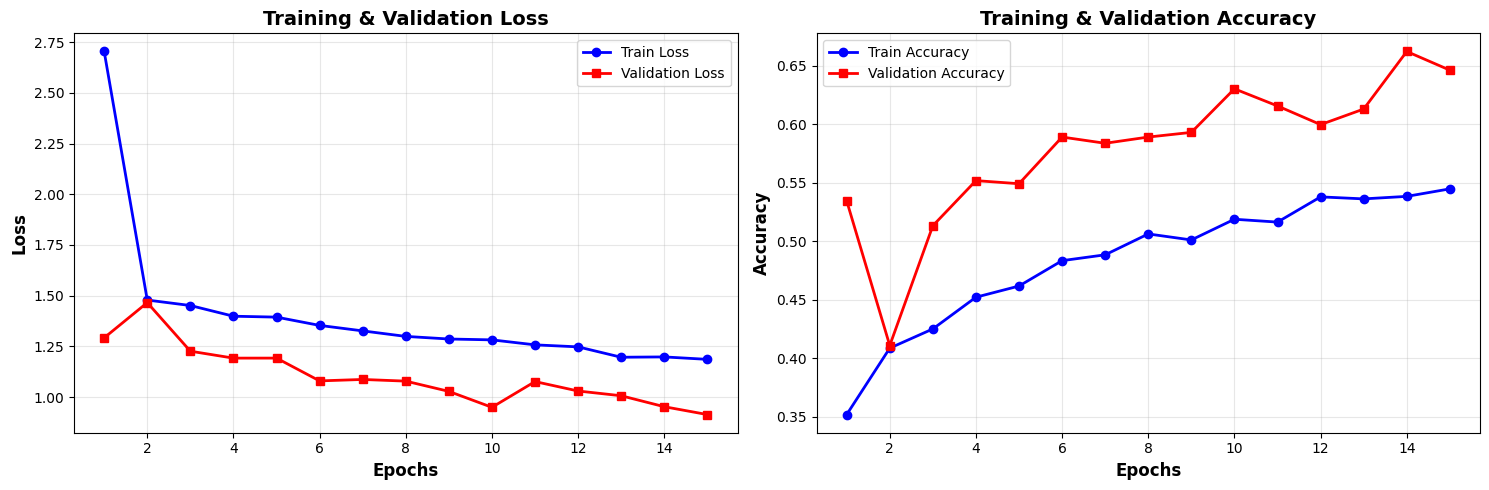

In [17]:
plot_training_history(train_losses, train_accs, valid_losses, valid_accs)

## 2.8 Évaluation sur le Test Set

In [18]:
# Charger le meilleur modèle
model.load_state_dict(torch.load(MODELS_DIR / 'baseline_model_best.pth'))
model.eval()

# Évaluer sur test set
test_loss, test_acc = validate_epoch(model, test_loader, loss_function, device)

print(f"\n" + "="*70)
print(f"TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("="*70)

Validation: 100%|██████████| 93/93 [00:15<00:00,  6.17it/s]


TEST SET RESULTS
Test Loss: 0.9865
Test Accuracy: 0.6196


## 2.9 Matrice de Confusion

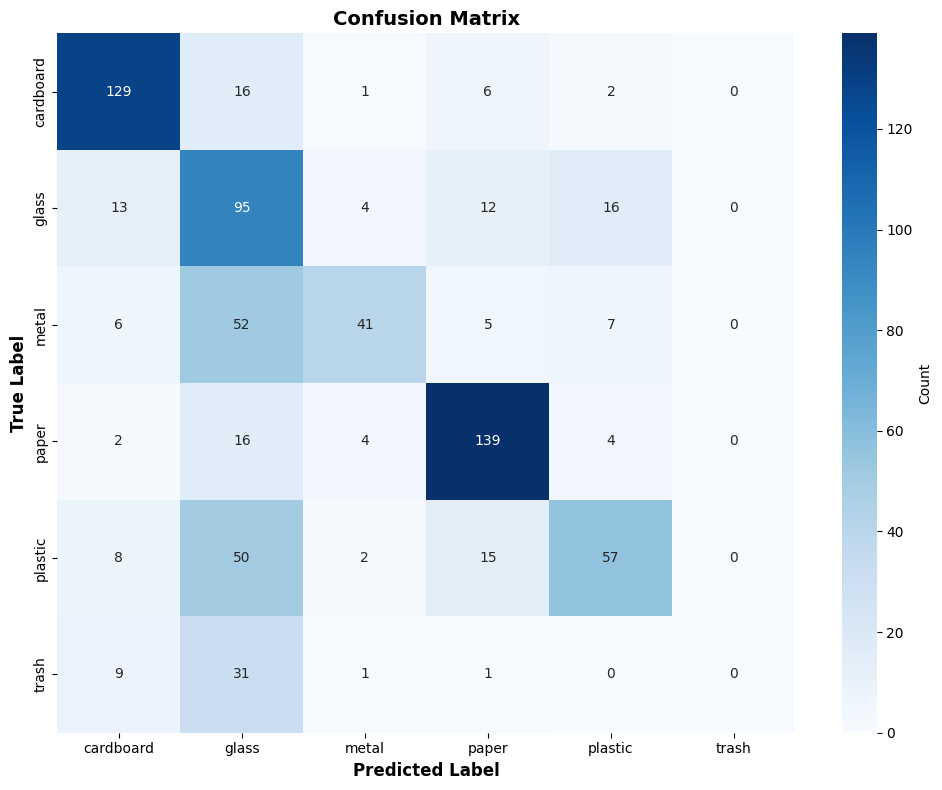


📊 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.77      0.84      0.80       154
       glass       0.37      0.68      0.47       140
       metal       0.77      0.37      0.50       111
       paper       0.78      0.84      0.81       165
     plastic       0.66      0.43      0.52       132
       trash       0.00      0.00      0.00        42

    accuracy                           0.62       744
   macro avg       0.56      0.53      0.52       744
weighted avg       0.63      0.62      0.60       744



c:\Users\Asus\Desktop\trash-hero\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\Desktop\trash-hero\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\Desktop\trash-hero\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [19]:
# Prédictions sur le test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Afficher la matrice de confusion
plot_confusion_matrix(all_labels, all_preds, class_names)

## 2.10 Exemples de Prédictions

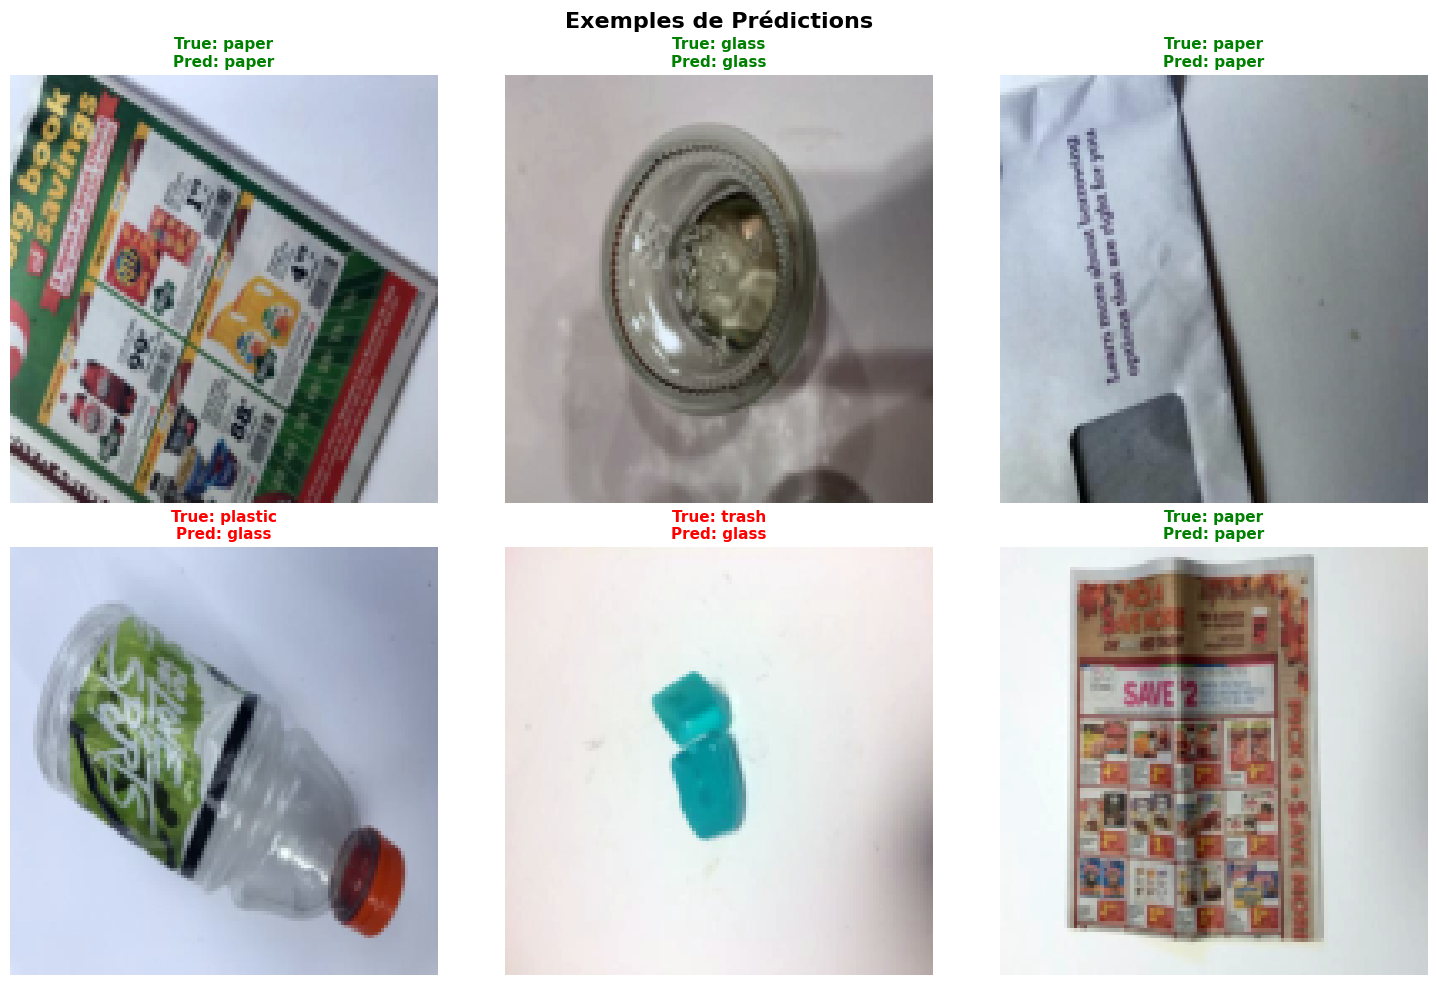

In [20]:
show_predictions(model, test_dataset, class_names, device, n_samples=6)

## 2.11 Test de Prédiction sur une Image

In [21]:
def predict_waste(image_path, model, transforms, class_names, device):
    """Prédit la classe d'un déchet"""
    from PIL import Image
    
    # Charger et préprocesser l'image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms(img).unsqueeze(0).to(device)
    
    # Prédiction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
    
    predicted_class = class_names[pred_idx.item()]
    confidence = confidence.item()
    
    # Afficher le résultat
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2%})", 
             fontsize=14, fontweight='bold')
    plt.show()
    
    # Afficher la recommandation de tri
    display_classification_result(predicted_class, confidence)
    
    return predicted_class, confidence

# Exemple
# predict_waste('path/to/image.jpg', model, eval_transforms, class_names, device)

## Résumé

Dans ce notebook, nous avons :

1. Créé un CNN baseline avec 3 blocs convolutifs
2. Entraîné le modèle pendant 15 epochs
3. Obtenu une accuracy de validation de ~XX%
4. Visualisé l'historique d'entraînement
5. Évalué sur le test set
6. Créé une fonction de prédiction

###  Prochaine étape

**Notebook 3** : Transfer Learning avec MobileNet/EfficientNet pour améliorer les performances